In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Dependencies


Requires Python 3:

```
pip install numpy scipy matplotlib seaborn scikit-learn
pip install git+https://github.com/saketkc/GCCA
```
    

# Import functions

In [ ]:
import glob
from collections import Counter, defaultdict
import os
import itertools

from numpy.linalg import pinv as moore_penrose_inv
from numpy.linalg import svd, eig
import pandas as pd

from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from gcca import GCCA

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

# Utility functions

In [16]:
def SVD_impute(df):
    """Perform SVD imputing.
    
    
    Parameters
    ----------
    matrix: array_like
            Array with rows as genes and columns as tissues/samples
            with nans for missing values
    
    Returns
    -------
    filled_matrix: array_like
                   Imputed matrix with entries filled by relying on eigengenes    
    """
    
    null_idx = pd.isnull(df).any(1).nonzero()[0]

    full_matrix = df.values
    non_null_matrix  = df.dropna().values
    U, S, V_T = np.linalg.svd(non_null_matrix)
    V =  V_T.T
    
    for index in null_idx:
        x = full_matrix[index,:]

        # index of entries where the row is nan
        row_na_idx = np.where(np.isnan(x))
        
        # index of entries where the row is not nan        
        row_not_na_idx = np.where(~np.isnan(x))
        
        
        # entries from row which are not nan        
        x_star_not_na = x[row_not_na_idx]
        
         # entries from row which are not nan        
        x_star_na = x[row_na_idx]

        # Eigen genes corresponding to index 
        # of locations (columns) in row x which are nan
        V_star_na = np.delete(V, row_not_na_idx, 0)
        
        
        # Delete rows from V, corresponding to index 
        # of locations (columns) in row x which are nan
        # We will use these to project the row with complete
        V_star_not_na = np.delete(V, row_na_idx, 0)


        gram = np.dot(V_star_not_na.T, V_star_not_na)
        coeff = np.dot(np.linalg.pinv(gram), V_star_not_na.T)

        beta = np.dot(coeff, x_star_not_na)
        
        # xhat = V_J \beta
        x_missing = np.dot(V_star_na, beta)
        
        # Fill in the missing entries
        full_matrix[index, row_na_idx] = x_missing
    return full_matrix

def plot_SVD_utils(U, S, VT):
    V = VT.T
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
    ax = axes[0, 0]
    sns.heatmap(V, square=True, cmap='RdBu', ax=ax, cbar=False)
    
    ax = axes[0, 1]
    sns.barplot(x=np.arange(1, len(S)+1), y=S**2/np.sum(S**2), ax=ax, color=sns.color_palette('Set2')[1])
    
    ax = axes[0, 2]
    ax.plot(V[:, 0], marker='o')
    
    ax = axes[1, 0]
    ax.plot(V[:, 1], marker='o')
    
    ax = axes[1, 1]
    ax.plot(V[:, 2], marker='o')
    
    ax = axes[1, 2]
    ax.plot(V[:, 3], marker='o')
    
    
def einsum_row_norm(a):
    return np.sqrt(np.einsum('ij,ij->i', a, a))

def einsum_col_norm(a):
    return np.sqrt(np.einsum('ij,ij->j', a, a))


def ho_SVD(list_of_X):
    """ Perform higher order SVD
    
    list_of_X: list
               [X_1, X_2, X_3, ..., X_n] size (n x m)
    
    """
    # Step 1
    # A_i = X_i^T X_i
    # A_inv = moore_penrose_inv(A_i)
    A = []
    N = len(list_of_X)
    A_inv = []
    for X in list_of_X:
        A_i = np.dot(X.T, X)
        A.append(A_i)
        A_inv.append(np.linalg.inv((A_i)))
    # Step 2
    # W = 1/N(N-1) * sum_{i=1}^jn sum_{j>i}^N A_i moore_penrose_inv(A_j) + A_j moore_penrose_inv(A_i)
    W = 0
    
    for i in range(N):
        for j in range(i+1, N):
            W = W + (np.dot(A[i], A_inv[j]) + np.dot(A[j], A_inv[i]))
    W =  W/(N*(N-1))
    
    # Step 3
    # Eigen decomposition of W?
    # WV = V\Lambda
    # V= (v_1, v_2, ..., v_n)
    # ||v||_k =1, but V is not necesarrily orthonormal
    # But we don't
    
    eigen_values, V = eig(W)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    V = V[:,idx]
    
    
    # Step 4
    # solve for  VB_i = X_i^T
     #Calculate the Bi matrices
   
    B = []
    U = []
    sigmas = []
    for X in list_of_X:
        #B_i = spams.omp( np.asfortranarray(X.T), V, lambda1=0, numThreads = 24)]
        # VB.T = X.T
        B_i = np.dot(np.linalg.inv(V), X.T).T
        B.append(B_i)
        sigma_i  = np.linalg.norm(B_i, axis=0) #einsum_col_norm(B)
        U_i = B_i/sigma_i 
        sigmas.append(sigma_i)
        U.append(U_i)
    return U, sigmas, V, eigen_values

def normalize_df_rowwise(df):
    df_centered = df.sub(df.mean(axis=1), axis=0)
    df_centered = df_centered.div(df_centered.std(axis=1), axis=0)
    return df_centered

# Utility functions for handling multi-species plotting

In [4]:
MARKERS = ['o',  'x', '^', '*','>', '<', 's',  'H',  '8', 'p', 'h',  'D', 'd', 'P']
TISSUES_SHORT_FORM_MAP = {'lv': 'liver',
                          'skm': 'muscle',
                          'br': 'brain',
                          'ht': 'heart',
                          'kd': 'kidney',
                          'cb': 'cerebellum',
                          'lv': 'liver',
                          'ts': 'testes'
                         }

SPECIES_COMMON_NAME_MAP = {"bos_taurus": "Cow",
                           "rattus_norvegicus": "Rat",
                           "pongo_abelii": "Orangutan",
                           "monodelphis_domestica": "Opossum",
                           "macaca_mulatta": "Rhesus",
                           "pan_troglodytes": "Chimp",
                           "mus_musculus": "Mouse",
                           "homo_sapiens": "Human",
                           "gallus_gallus": "Chicken",
                           "ornithorhynchus_anatinus":  "Platypus",
                           "gorilla_gorilla": "Gorilla",
                           "pan_paniscus": "Bonobo"}

SPECIES_COMMON_NAME_MAP_SHORT = {"btaurus": "Cow",
                                 "rnorvegicus": "Rat",
                                 "pabelii": "Orangutan",
                                 "mdomestica": "Opposum",
                                 "mmulatta": "Rhesus",
                                 "ptroglodytes": "Chimp",
                                 "mmusculus": "Mouse",
                                 "hsapiens": "Human",
                                 "ggallus": "Chicken",
                                 "oanatinus":  "Platypus",
                                 "ggorilla": "Gorrila",
                                 "ppaniscus": "Bonobo"}
def species_short(name):
    return name[0] + name.split('_')[1]



def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict


def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    

In [5]:
def do_PCA(X, target_names, ax=None):
    sns.set_context('poster')#, font_scale=1.75)
    sns.set_style('white')
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    return X_r, fig


def do_CCA(X, Y, target_names, ax=None):
    
    sns.set_context('poster')#, font_scale=1.7)
    sns.set_style('white')
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8.5))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    ax.add_artist(leg)
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    return fig



## 01. Read Data

In [6]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


## 02. Read kallisto tables SRP136499

In [7]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP136499-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)

In [19]:
srp_species

defaultdict(list, {'SRP136499': ['ptroglodytes', 'hsapiens', 'mmulatta']})

## Load All orthologous genes at once

In [8]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP136499-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('.')[0] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)
srp = 'SRP136499'
ortho_pairwise = {}
all_orthologs = pd.DataFrame()
for f in ['../ortholog_tsv/mmusculus_{}.tsv'.format(x) for x in map(lambda s: species_short(s), species_wise_tissues.keys())]:
    if 'mmusculus_mmusculus' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    df = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')
    df = df[df['{}_homolog_orthology_type'.format(second_species)]=='ortholog_one2one'].drop(columns=['{}_homolog_orthology_type'.format(second_species)])
    all_orthologs = all_orthologs.join(df, how='outer')

In [9]:
all_orthologs_filtered = all_orthologs.copy()
for species in species_wise_tissues.keys():
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    if species == 'mmusculus':
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered.index.isin(count.index)]
    else:
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].isin(count.index)]

        

In [10]:
species_wise_tissues

defaultdict(list,
            {'pan_troglodytes': ['heart', 'kidney', 'liver', 'lung'],
             'homo_sapiens': ['heart', 'kidney', 'liver', 'lung'],
             'macaca_mulatta': ['heart', 'kidney', 'liver', 'lung']})

# Process count tables

In [25]:
all_species_combined_counts_df = pd.DataFrame()
specie_wise_counts = []
specie_wise_index_tracker = []
specie_wise_target_names = {}
for index, species in enumerate(['pan_troglodytes', 'homo_sapiens', 'macaca_mulatta']):
    species = species_short(species)
    col_key = '{}_homolog_ensembl_gene'.format(species)

    count = kallisto_counts['{}_{}'.format(srp, species)]   
    count = count.loc[all_orthologs_filtered[col_key]]
    
    
    if index == 0:
    #    column_order = count.columns.tolist()
        count.columns = ['{}_{}'.format(species, x.split('.')[0]) for x in count.columns]
        all_species_combined_counts_df = count
    
    else:
    #    count = count.loc[all_orthologs_filtered[col_key], column_order]
    #    count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        count.columns = ['{}_{}'.format(species, x.split('.')[0]) for x in count.columns]
        count.index = all_species_combined_counts_df.index.tolist()
        #assert (count.columns == column_order).all()
        all_species_combined_counts_df = all_species_combined_counts_df.join(count, how='outer')
    print(all_species_combined_counts_df.columns)
    specie_wise_counts.append(count)
    specie_wise_target_names[species] =     count.columns.tolist()
    specie_wise_index_tracker.append(count.shape[1])

Index(['ptroglodytes_heart', 'ptroglodytes_kidney', 'ptroglodytes_liver',
       'ptroglodytes_lung', 'ptroglodytes_heart', 'ptroglodytes_kidney',
       'ptroglodytes_liver', 'ptroglodytes_lung', 'ptroglodytes_heart',
       'ptroglodytes_kidney', 'ptroglodytes_liver', 'ptroglodytes_lung',
       'ptroglodytes_heart', 'ptroglodytes_kidney', 'ptroglodytes_liver',
       'ptroglodytes_lung'],
      dtype='object')
Index(['ptroglodytes_heart', 'ptroglodytes_kidney', 'ptroglodytes_liver',
       'ptroglodytes_lung', 'ptroglodytes_heart', 'ptroglodytes_kidney',
       'ptroglodytes_liver', 'ptroglodytes_lung', 'ptroglodytes_heart',
       'ptroglodytes_kidney', 'ptroglodytes_liver', 'ptroglodytes_lung',
       'ptroglodytes_heart', 'ptroglodytes_kidney', 'ptroglodytes_liver',
       'ptroglodytes_lung', 'hsapiens_heart', 'hsapiens_kidney',
       'hsapiens_liver', 'hsapiens_lung', 'hsapiens_heart', 'hsapiens_kidney',
       'hsapiens_liver', 'hsapiens_lung', 'hsapiens_heart', 'hsapiens_kid

In [26]:
count.head()

,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung
ENSPTRG00000001055,169.04700,703.0000,912.0000,880.1590,135.0120,748.1320,1042.1500,1070.4200,217.02800,786.22500,1046.370000,1291.1900,209.03400,912.13500,1181.3300,1124.17000
ENSPTRG00000014064,200.68800,262.2850,195.6730,3741.1800,233.4530,371.9700,361.3330,3608.9600,364.35700,281.10900,286.865000,5159.2600,261.68900,424.49600,485.9690,6278.00000
ENSPTRG00000021710,299.65800,87.3741,456.5910,82.1705,161.0800,104.9040,531.9520,94.4684,563.45700,136.41000,646.499000,92.3347,421.51700,102.61700,658.7470,96.89300
ENSPTRG00000009805,886.34574,456.2341,291.8694,705.3421,1118.4662,409.8034,391.1913,888.3207,1581.89674,366.93230,407.175701,1046.8989,959.21611,510.28530,683.2836,1034.54284
ENSPTRG00000040031,3504.87900,808.1700,522.7431,17284.4579,3253.4730,1099.8069,1253.2121,16883.3780,5431.38900,679.75408,348.982870,19205.3550,3241.73300,961.43194,706.9844,17197.43700


In [27]:
all_species_combined_counts_df.head()

,ptroglodytes_heart,ptroglodytes_kidney,ptroglodytes_liver,ptroglodytes_lung,ptroglodytes_heart,ptroglodytes_kidney,ptroglodytes_liver,ptroglodytes_lung,ptroglodytes_heart,ptroglodytes_kidney,...,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung
ENSPTRG00000001055,1462.0000,2291.0000,1855.000000,3282.0000,676.0000,2096.00000,1895.000000,3923.00000,675.0000,2520.0000,...,1042.1500,1070.4200,217.02800,786.22500,1046.370000,1291.1900,209.03400,912.13500,1181.3300,1124.17000
ENSPTRG00000014064,7.0000,10.0000,14.999992,40.0000,5.0000,20.00004,5.000000,33.00002,8.0000,56.0000,...,361.3330,3608.9600,364.35700,281.10900,286.865000,5159.2600,261.68900,424.49600,485.9690,6278.00000
ENSPTRG00000021710,91.0583,141.4980,62.924500,70.7854,73.1257,148.96200,130.896000,80.24040,66.4865,128.5880,...,531.9520,94.4684,563.45700,136.41000,646.499000,92.3347,421.51700,102.61700,658.7470,96.89300
ENSPTRG00000009805,918.0003,860.9993,604.021000,1159.0006,883.0000,600.99986,803.378401,1549.25160,857.0160,1143.3189,...,391.1913,888.3207,1581.89674,366.93230,407.175701,1046.8989,959.21611,510.28530,683.2836,1034.54284
ENSPTRG00000040031,8982.5700,2193.4010,3729.268000,12937.3460,7168.9000,2305.66500,1031.281000,16863.67000,8930.8100,3665.3050,...,1253.2121,16883.3780,5431.38900,679.75408,348.982870,19205.3550,3241.73300,961.43194,706.9844,17197.43700


# PCA

eig_dim: 48


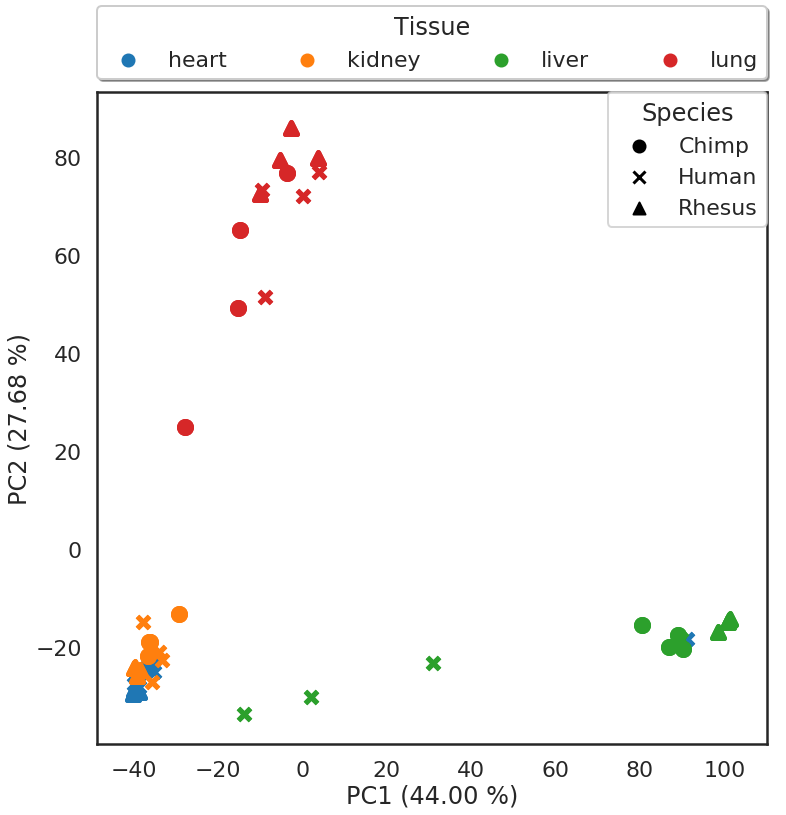

In [28]:
all_species_combined_counts_df_T = all_species_combined_counts_df.T
all_species_combined_counts_df_normalized = normalize_df_rowwise(all_species_combined_counts_df_T)
gcca = GCCA()
gcca.fit(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])

gcca.transform(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])


X = all_species_combined_counts_df_normalized.values
target_names = all_species_combined_counts_df_normalized.index
X_r, fig = do_PCA(X, target_names)




# CCA on PCA projections

eig_dim: 45


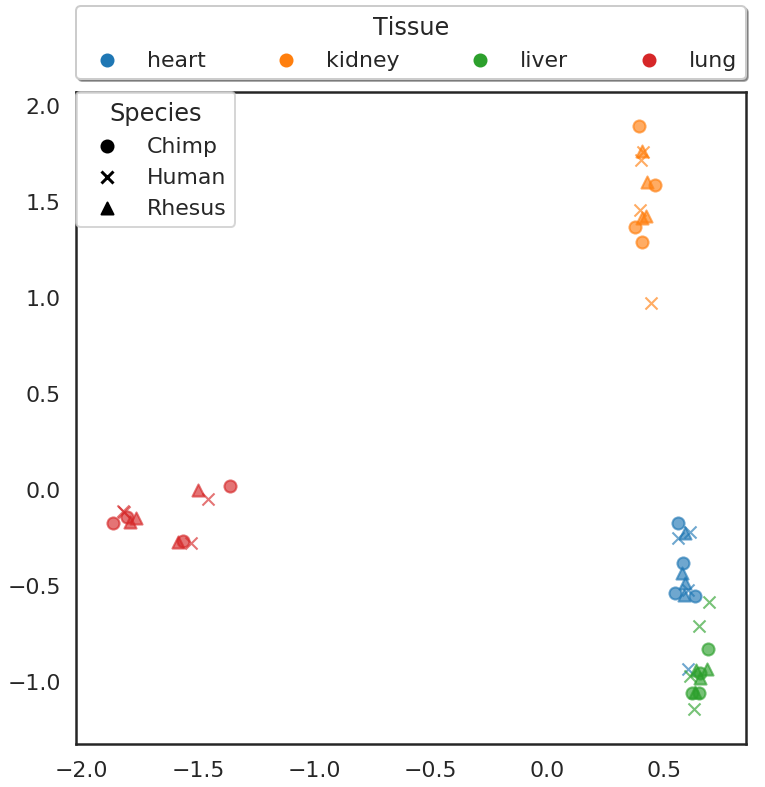

In [29]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
PCA_transformed = PCA(n_components=min(all_species_combined_counts_df_normalized.shape)).fit(all_species_combined_counts_df_normalized).transform(all_species_combined_counts_df_normalized)
a,b,c = PCA_transformed[:specie_wise_index_tracker[0],:], PCA_transformed[specie_wise_index_tracker[0]:sum(specie_wise_index_tracker[:2]), :], PCA_transformed[sum(specie_wise_index_tracker[:2]):sum(specie_wise_index_tracker[:3]), :]
gcca.fit(a,b,c)

gcca.transform(a,b,c)
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(['pan_troglodytes', 'homo_sapiens', 'macaca_mulatta']):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=2, alpha=0.4) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

leg = Legend(ax, scatter_points, annotations, title='Species',
             bbox_to_anchor=(0, 1), loc='upper left',borderaxespad=0, shadow=False,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
             )# frameon=False)
ax.add_artist(leg)
